In [50]:
from sklearn import metrics
import seaborn as sns

In [51]:
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [52]:
from pylab import *
import numpy as np
from os import listdir
from sklearn.svm import LinearSVC
import cv2
from PIL import Image
from sklearn import svm
import imagehash
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model


def preprocess_image(path, display=False):
    raw_image = cv2.imread(path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    #bw_image = 255 - bw_image

    if display:
        cv2.imshow("RGB to Gray", bw_image)
        cv2.waitKey()

    #_, threshold_image = cv2.threshold(bw_image, 30, 255, 0)

    #if display:
     #   cv2.imshow("Threshold", threshold_image)
      #  cv2.waitKey()

    #return threshold_image
    return bw_image

def sift(im, path, display=False):
    raw_image = cv2.imread(path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)

    if display:
        cv2.drawKeypoints(im, kp, raw_image)
        cv2.imshow('sift_keypoints.jpg', cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        cv2.waitKey()

    return (path, des)


des_list = []


genuine_image_filenames = listdir("signatures/full_org")
forged_image_filenames = listdir("signatures/full_forg")

genuine_image_paths = "signatures/full_org"
forged_image_paths = "signatures/full_forg"

genuine_image_features = [[] for x in range(55)]
forged_image_features = [[] for x in range(55)]

for name in genuine_image_filenames[0:1320]:
    signature_id = int(name.split('_')[1])
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames[0:1320]:
    signature_id = int(name.split('_')[1])
    forged_image_features[signature_id - 1].append({"name": name})
    

cor = 0
wrong = 0
acc=[]
for itr in range(10):
    for i in range(55):
        des_list = []
        for im in genuine_image_features[i]:
            image_path = genuine_image_paths + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            des_list.append(sift(preprocessed_image, image_path))

        for im in forged_image_features[i]:
            image_path = forged_image_paths + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            des_list.append(sift(preprocessed_image, image_path))

        descriptors = des_list[0][1]
        for image_path, descriptor in des_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))
        k = 300
        voc, variance = kmeans(descriptors, k, 1)
        im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k), "float32")

        for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
            words, distance = vq(des_list[i][1], voc)
            for w in words:
                im_features[i][w] += 1

        stdSlr = StandardScaler().fit(im_features)
        im_features = stdSlr.transform(im_features)
        train_genuine_features, test_genuine_features = im_features[0:15], im_features[15:24]

        train_forged_features, test_forged_features = im_features[24:39], im_features[39:]
        
        true_labels=np.array([1 for x in range(len(test_forged_features))] + [2 for x in range(len(test_genuine_features))])
        
        
        clf = LinearSVC()
        clf.fit(np.concatenate((train_forged_features,train_genuine_features)), np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

        genuine_res = clf.predict(test_genuine_features)

        for res in genuine_res:
            if int(res) == 2:
                cor += 1
            else:
                wrong += 1

        #print("1" + str(clf.predict(test_forged_features)))
        forged_res = clf.predict(test_forged_features)

        for res in forged_res:
            if int(res) == 1:
                cor += 1
            else:
                wrong += 1
                
        pred_labels=np.concatenate([forged_res,genuine_res])
        #pretty_cm(pred_labels, true_labels, ['Genuine', 'Forge'])
    
    fin_res=float(cor)/(cor+wrong)
    print(float(cor)/(cor+wrong))
    acc.append(fin_res)

1.0
1.0
1.0
0.9992424242424243
0.9993939393939394
0.9993265993265993
0.9992784992784993
0.9993686868686869
0.9992143658810325
0.9990909090909091


In [53]:
np.mean(acc)

0.9994915424082091

In [26]:
true_labels=np.array([1 for x in range(len(test_forged_features))] + [2 for x in range(len(test_genuine_features))])    

In [27]:
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [28]:
genuine_res

array([2, 2, 2, 2])

In [29]:
len(test_genuine_features)

4

In [30]:
forged_res

array([1, 1, 1, 1])

In [31]:
len(test_forged_features)

4

In [32]:
true_labels

array([1, 1, 1, 1, 2, 2, 2, 2])

In [40]:
pred_labels=np.concatenate([forged_res,genuine_res])

In [41]:
pred_labels

array([1, 1, 1, 1, 2, 2, 2, 2])

In [44]:
from sklearn import metrics
import seaborn as sns

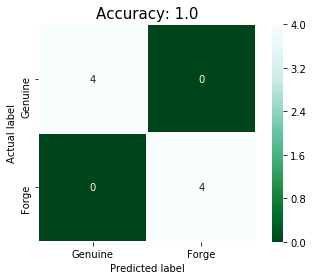

In [45]:
pretty_cm(pred_labels, true_labels, ['Genuine', 'Forge'])

In [20]:
len(genuine_image_features[0])

24

In [21]:
len(im_features)

48

In [ ]:
genuine_image_filenames = listdir("signatures/full_org")
forged_image_filenames = listdir("signatures/full_forg")

genuine_image_paths = "signatures/full_org"
forged_image_paths = "signatures/full_forg"

genuine_image_features = [[] for x in range(55)]
forged_image_features = [[] for x in range(55)]



In [ ]:
genuine_image_filenames

In [ ]:
import pandas as pd

In [ ]:
pd.options.display.max_rows=4000

In [ ]:
for name in genuine_image_filenames[0:1320]:
    signature_id = int(name.split('_')[1])
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames[0:1320]:
    signature_id = int(name.split('_')[1])
    forged_image_features[signature_id - 1].append({"name": name})

In [ ]:
len(genuine_image_filenames)

In [ ]:
genuine_image_features[0]

# CNN

In [ ]:
genuine_image_filenames = listdir("trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine")
forged_image_filenames = listdir("trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries")

genuine_image_paths = "trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine"
forged_image_paths = "trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries"

train_X=[]
train_Y=[]
for im in genuine_image_filenames:
    image_path = genuine_image_paths + "/" + im
    img=cv2.imread(image_path)
    train_X.append(img)
    train_Y.append(1)

for im in forged_image_filenames:
    image_path = forged_image_paths + "/" + im
    img=cv2.imread(image_path)
    train_X.append(img)
    train_Y.append(0)

        

In [ ]:
np.shape(train_X)

In [ ]:
train_Y

In [ ]:
plt.imshow(train_X[0])

In [ ]:
np.shape(train_X[3])

In [ ]:
from PIL import Image

In [ ]:
train_X_new=[]
for i in train_X:
    train_X_new.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))

In [ ]:
train_X_final=[]
for i in train_X_new:
    img=cv2.resize(i, (120,120), interpolation = cv2.INTER_AREA)
    train_X_final.append(img)

In [ ]:
plt.imshow(train_X_final[0])

In [ ]:
from keras.utils import to_categorical

In [ ]:
train_X_final[0].shape

In [ ]:
train_X_final=np.array(train_X_final)

train_X = train_X_final.reshape(-1, 120,120, 1)
#test_X = test_X_final.reshape(-1, 120,120, 1)
#train_X.shape, test_X.shape

In [ ]:
train_X.shape

In [ ]:
train_X.shape

In [ ]:
train_X = train_X.astype('float32')
#test_X = test_X_final.astype('float32')
train_X = train_X / 255.
#test_X = test_X / 255.

In [ ]:
type(train_X)

In [ ]:
train_Y_one_hot = to_categorical(train_Y)
#test_Y_one_hot = to_categorical(test_Y)

In [ ]:
train_Y_one_hot

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [ ]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
batch_size = 73
epochs = 20
num_classes = 2

In [ ]:
signature_model = Sequential()
signature_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(120,120,1),padding='same'))
signature_model.add(LeakyReLU(alpha=0.001))
signature_model.add(MaxPooling2D((2, 2),padding='same'))
signature_model.add(Dropout(0.25))

signature_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
signature_model.add(LeakyReLU(alpha=0.001))
signature_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
signature_model.add(Dropout(0.25))

signature_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
signature_model.add(LeakyReLU(alpha=0.001))
signature_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
signature_model.add(Dropout(0.4))


signature_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
signature_model.add(LeakyReLU(alpha=0.001))                  
signature_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
signature_model.add(Dropout(0.3))

signature_model.add(Flatten())
signature_model.add(Dense(128, activation='linear'))
signature_model.add(LeakyReLU(alpha=0.001))      
signature_model.add(Dropout(0.25))

signature_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
signature_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
signature_model.summary()

In [ ]:
signature_train = signature_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))